In [1]:
##基本統計量の確認
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\houbo\stock-price-predictor\notebooks\data\stock_price.csv")

#日付のデータを日付データ型に変換
df["日付け"] = pd.to_datetime(df["日付け"])


#出来高のデータはMで終わるものやBで終わるものがあるので、終端のM,Bを取り除いて、float型の数値として出力しそれをそれぞれ100万倍、1億倍したものを返す関数。
def adjustment(volume_str):
    if isinstance(volume_str, str):
        volume_str = volume_str.strip()
        if volume_str.endswith("M"):
            return float(volume_str[:-1])*1_000_000
        elif volume_str.endswith("B"):
            return float(volume_str[:-1])*1_000_000_000
    return None           

df["出来高"] = df["出来高"].apply(adjustment)
df["変化率 %"] = df["変化率 %"].str.replace("%","").astype(float)

print("基本統計量")
display(df[["終値","始値","高値","安値","出来高","変化率 %"]].describe())




基本統計量


,終値,始値,高値,安値,出来高,変化率 %
count,9202.000000,9202.000000,9202.000000,9202.000000,9.202000e+03,9202.000000
mean,92.180961,92.256183,93.176451,91.330146,1.726677e+08,0.017502
std,50.452228,50.598215,51.049837,50.087405,1.251280e+08,1.876667
min,33.000000,33.000000,33.200000,32.200000,9.340000e+06,-14.740000
25%,52.000000,52.100000,52.800000,51.500000,8.073000e+07,-0.940000
50%,85.100000,85.100000,86.050000,84.200000,1.540150e+08,0.000000
75%,110.800000,110.800000,111.900000,109.275000,2.305225e+08,0.900000
max,305.900000,309.800000,311.800000,303.900000,1.280000e+09,16.250000


Text(0, 0.5, '終値')

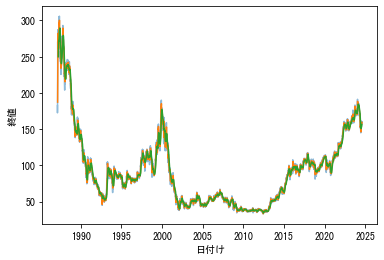

In [2]:
##時系列トレンドの把握
import matplotlib.pyplot as plt

df.set_index('日付け', inplace=True)
df.sort_index(inplace=True)

df["終値_週平均"]=df["終値"].rolling(window=7).mean()
df["終値_月平均"]=df["終値"].rolling(window=30).mean()

plt.rcParams['font.family'] = 'MS Gothic'
plt.plot(df["終値"],label="終値",alpha=0.5)
plt.plot(df["終値_週平均"],label="終値_週平均")
plt.plot(df["終値_月平均"],label="終値_月平均")
plt.xlabel("日付け")
plt.ylabel("終値")

長期的なトレンドが見受けられる。
・バブル崩壊（1990年前後）
・ITバブル期と崩壊（続く2000年前後での山）
・リーマンショック（2008年）
・回復（2010年前後～2020年前後）
・コロナの社会での需要拡大（2021年～）

*非線形性

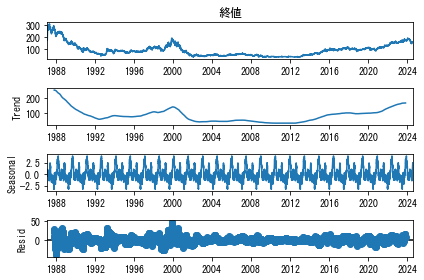

In [5]:
##季節性の確認

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df["終値"],model="addictive",period=365)


fig = decomposition.plot()
plt.show()

季節的周期性が見受けられる。

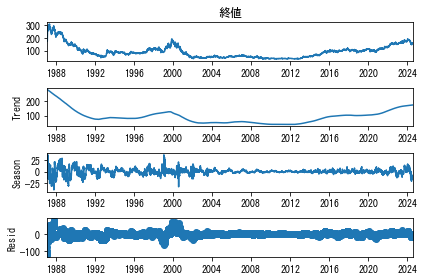

In [ ]:
##季節性の確認STL分解
from statsmodels.tsa.seasonal import STL

stl = STL(df["終値"],period=365,robust=True)
stl_result = stl.fit()


fig_stl = stl_result.plot()
plt.show()

season成分に周期的な変化が見受けられることから、季節性が確認できる。

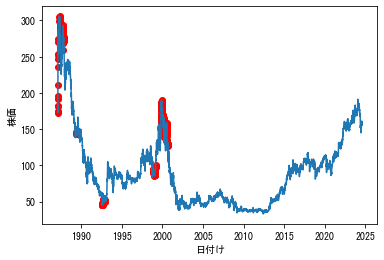

In [ ]:
##異常値の検出
resid = stl_result.resid
threshold = 3 * resid.std()

df["異常値_STL"] = abs(resid) > threshold

plt.plot(df["終値"],label="終値")
plt.scatter(df[df["異常値_STL"]].index, df[df["異常値_STL"]]["終値"],color="red",label="異常値")

plt.xlabel("日付け")
plt.ylabel("株価")

plt.show()

閾値より高い値を異常値とし、プロットした。

モデルの決定

・明確なトレンド、季節性の存在が確認できた。
・グラフから急激な値の変動や非線形性がみられる。
    （株価という数値の性質上、企業の業績や国際情勢、人間の心理など様々な要因が複雑　に絡み合ってその値が変化するため、非線形的な変化がみられる。また、それにより　定常性は認められないのでARIMAモデルはあまり適切でない）
・長期的なトレンドに依存して変化しているととれる部分もある。

以上の理由から、トレンド、季節性のあるデータに適し、かつ非線形な変化への対応力や長期的な影響に対する学習力という点で優れたLSTMを予測モデルとして選択することにする。